In [ ]:
!pip install cirq matplotlib numpy scipy bayesian-optimization tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
import cirq
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy.optimize import minimize
from bayes_opt import BayesianOptimization
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque
import random

In [ ]:
# Gate selection based on the application
def select_gate_for_application(application):
    application_to_gate = {
        'coin flip': 'H',
        'bit flip': 'X',
        'phase flip': 'Z',
        'bitwise not': 'Y'
    }
    gate_type = application_to_gate.get(application.lower(), 'H')
    return gate_type

In [ ]:
# Create quantum circuit based on the selected gate
def create_circuit(gate_type):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()

    if gate_type == 'H':
        circuit.append(cirq.H(qubit))
    elif gate_type == 'X':
        circuit.append(cirq.X(qubit))
    elif gate_type == 'Y':
        circuit.append(cirq.Y(qubit))
    elif gate_type == 'Z':
        circuit.append(cirq.Z(qubit))
    else:
        print("Invalid gate type. Defaulting to Hadamard gate.")
        circuit.append(cirq.H(qubit))

    circuit.append(cirq.measure(qubit, key='result'))
    return circuit

In [ ]:
# Minimize circuit depth using a greedy approach
def minimize_circuit_depth_greedy(circuit):
    qubits = list(circuit.all_qubits())
    layers = []
    qubit_layers = {q: [] for q in qubits}

    for moment in circuit:
        new_moment = cirq.Moment()
        for op in moment.operations:
            qubit = op.qubits[0]
            if len(qubit_layers[qubit]) == 0:
                new_moment = new_moment.with_operation(op)
                qubit_layers[qubit].append(op)
            else:
                if not any(op.gate == prev_op.gate for prev_op in qubit_layers[qubit]):
                    new_moment = new_moment.with_operation(op)
                    qubit_layers[qubit].append(op)

        if new_moment.operations:
            layers.append(new_moment)

    optimized_circuit = cirq.Circuit(layers)
    return optimized_circuit

In [ ]:
# Reduce gate count using template matching and peephole optimization
def gate_count_reduction(circuit):
    templates = {
        'H': cirq.Circuit([cirq.H(cirq.GridQubit(0, 0))]),
        'X': cirq.Circuit([cirq.X(cirq.GridQubit(0, 0))]),
        'Z': cirq.Circuit([cirq.Z(cirq.GridQubit(0, 0))]),
        'Y': cirq.Circuit([cirq.Y(cirq.GridQubit(0, 0))])
    }

    optimized_circuit = cirq.Circuit()
    operations = set()

    for moment in circuit:
        new_moment = cirq.Moment()
        for op in moment.operations:
            if op not in operations:
                new_moment = new_moment.with_operation(op)
                operations.add(op)
        if new_moment.operations:
            optimized_circuit = optimized_circuit + new_moment

    return optimized_circuit

In [ ]:
# Gradient Descent optimization
def gradient_descent_optimizer(circuit):
    def cost_function(params):
        return np.sum(params**2)

    initial_params = np.zeros(1)
    result = minimize(cost_function, initial_params, method='BFGS')
    optimized_params = result.x
    return optimized_params


In [ ]:

# Bayesian Optimization
def bayesian_optimization_optimizer(circuit):
    def cost_function(param):
        return -param**2 + 1

    optimizer = BayesianOptimization(
        f=cost_function,
        pbounds={'param': (-1, 1)},
        random_state=1,
    )
    optimizer.maximize(init_points=5, n_iter=10)
    best_params = optimizer.max['params']
    return best_params


In [ ]:
# DQN (Deep Q-Network) implementation
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = models.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, state, action, reward, next_state, done):
        self.remember(state, action, reward, next_state, done)
        if len(self.memory) > 32:
            self.replay(32)


In [ ]:
# Visualize results of the simulation
def visualize_results(results):
    measurements = results.measurements['result'].flatten()
    counts = Counter(measurements)
    total_counts = sum(counts.values())

    print("Measurement Results:", dict(counts))

    fig, ax = plt.subplots()
    bars = ax.bar(counts.keys(), counts.values(), color=['blue', 'orange'])

    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_counts) * 100
        ax.text(bar.get_x() + bar.get_width() / 2, height,
                f'{percentage:.2f}%',
                ha='center', va='bottom')

    probable_result = max(counts.items(), key=lambda x: x[1])[0]
    print(f"Most probable result: {probable_result}")

    ax.set_xlabel('Measurement Result')
    ax.set_ylabel('Count')
    ax.set_title('Measurement Results Histogram')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['0', '1'])

    plt.show()

In [ ]:
# Main function to run the simulation and optimization
def main():
    print("Ripples")

    application = input("Enter the application (e.g., 'coin flip', 'bit flip'): ")
    gate_type = select_gate_for_application(application)
    print(f"Selected Gate for '{application}': {gate_type}")

    try:
        repetitions = int(input("Enter the number of repetitions for the simulation: "))
    except ValueError:
        print("Invalid number. Defaulting to 1024 repetitions.")
        repetitions = 1024

    circuit = create_circuit(gate_type)
    print("Quantum Circuit:")
    print(circuit)

    optimization_method = input("Select optimization method (depth reduction/gate count reduction/parameter optimization/none): ").strip().lower()

    if optimization_method == 'depth reduction':
        circuit = minimize_circuit_depth_greedy(circuit)
        print("Optimized Quantum Circuit (Depth Reduction):")
        print(circuit)
    elif optimization_method == 'gate count reduction':
        circuit = gate_count_reduction(circuit)
        print("Optimized Quantum Circuit (Gate Count Reduction):")
        print(circuit)
    elif optimization_method == 'parameter optimization':
        param_method = input("Select parameter optimization method (gradient descent/bayesian optimization/q-learning/dqn): ").strip().lower()
        if param_method == 'gradient descent':
            optimized_params = gradient_descent_optimizer(circuit)
            print(f"Optimized Parameters (Gradient Descent): {optimized_params}")
        elif param_method == 'bayesian optimization':
            best_params = bayesian_optimization_optimizer(circuit)
            print(f"Best Parameters (Bayesian Optimization): {best_params}")
        elif param_method == 'q-learning':
            actions = ['H', 'X', 'Y', 'Z']
            q_learning = QLearning(actions)
            state = 'initial'
            for _ in range(100):  # Simulated episodes
                action = q_learning.choose_action(state)
                reward = np.random.rand()  # Dummy reward
                next_state = 'next'
                q_learning.update_q_value(state, action, reward, next_state)
                state = next_state
            print("Q-Learning completed.")
        elif param_method == 'dqn':
            state_size = 1  # Simplified for demonstration
            action_size = 4  # Number of actions
            dqn = DQN(state_size, action_size)
            state = np.zeros((state_size,))
            for _ in range(100):  # Simulated episodes
                action = dqn.act(state)
                reward = np.random.rand()  # Dummy reward
                next_state = np.zeros((state_size,))
                done = False
                dqn.train(state, action, reward, next_state, done)
                state = next_state
            print("DQN training completed.")
        else:
            print("Invalid parameter optimization method.")
    else:
        print("No optimization applied.")

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)
    visualize_results(result)


Ripples
Selected Gate for 'bit flip': X
Quantum Circuit:
(0, 0): ───X───M('result')───


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

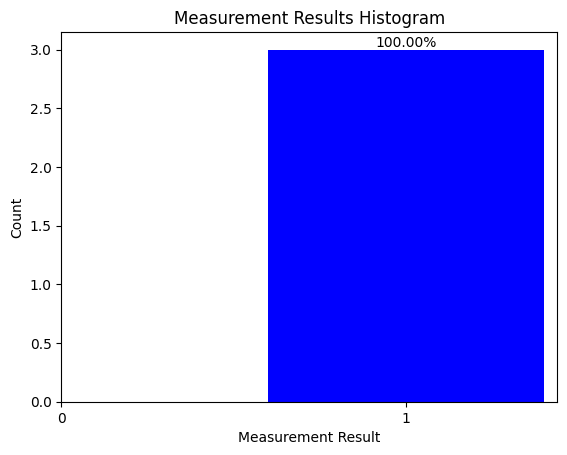

In [12]:

if __name__ == "__main__":
    main()
